In [1]:
from intake import open_catalog
cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/master.yaml")
list(cat)

/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['geojson', 'postgis', 'shapefile', 'spatialite'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


['ocean', 'atmosphere', 'climate', 'hydro']

In [60]:
ds = cat.atmosphere.era5_hourly_reanalysis_single_levels_sa.to_dask()
# pick a 20 year period to analyze
tp = ds.tp.sel(time=slice('1990-01-01', '2005-12-31'))
tp

,Array,Chunk
Bytes,582.48 GB,128.74 MB
Shape,"(140256, 721, 1440)","(31, 721, 1440)"
Count,15838 Tasks,4526 Chunks
Type,float32,numpy.ndarray


In [61]:
tp.data

,Array,Chunk
Bytes,582.48 GB,128.74 MB
Shape,"(140256, 721, 1440)","(31, 721, 1440)"
Count,15838 Tasks,4526 Chunks
Type,float32,numpy.ndarray


In [4]:
from dask_gateway import Gateway
gateway = Gateway()
cluster = gateway.new_cluster()
cluster

In [5]:
cluster.scale(30)

In [6]:
from dask.distributed import Client
client = Client(cluster)
client

Client Scheduler: gateway://traefik-ocean-prod-dask-gateway.ocean-prod:80/ocean-prod.0c3d6d486ef043d3819c7bec70ec489a Dashboard: https://ocean.pangeo.io/services/dask-gateway/clusters/ocean-prod.0c3d6d486ef043d3819c7bec70ec489a/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [62]:
import numpy as np
tp_6hr_bins = np.concatenate([[0], np.logspace(-5,  0, 50)])
tp_6hr_bins

array([0.00000000e+00, 1.00000000e-05, 1.26485522e-05, 1.59985872e-05,
       2.02358965e-05, 2.55954792e-05, 3.23745754e-05, 4.09491506e-05,
       5.17947468e-05, 6.55128557e-05, 8.28642773e-05, 1.04811313e-04,
       1.32571137e-04, 1.67683294e-04, 2.12095089e-04, 2.68269580e-04,
       3.39322177e-04, 4.29193426e-04, 5.42867544e-04, 6.86648845e-04,
       8.68511374e-04, 1.09854114e-03, 1.38949549e-03, 1.75751062e-03,
       2.22299648e-03, 2.81176870e-03, 3.55648031e-03, 4.49843267e-03,
       5.68986603e-03, 7.19685673e-03, 9.10298178e-03, 1.15139540e-02,
       1.45634848e-02, 1.84206997e-02, 2.32995181e-02, 2.94705170e-02,
       3.72759372e-02, 4.71486636e-02, 5.96362332e-02, 7.54312006e-02,
       9.54095476e-02, 1.20679264e-01, 1.52641797e-01, 1.93069773e-01,
       2.44205309e-01, 3.08884360e-01, 3.90693994e-01, 4.94171336e-01,
       6.25055193e-01, 7.90604321e-01, 1.00000000e+00])

In [64]:
# convert to 6-hourly precip totals
tp_6hr = tp.coarsen(time=6).sum()
tp_6hr

,Array,Chunk
Bytes,97.08 GB,24.92 MB
Shape,"(23376, 721, 1440)","(6, 721, 1440)"
Count,50536 Tasks,4526 Chunks
Type,float32,numpy.ndarray


In [65]:
from xhistogram.xarray import histogram

In [66]:
tp_hist = histogram(tp_6hr.rename('tp_6hr'), bins=[tp_6hr_bins], dim=['longitude']).mean(dim='time')
tp_hist.data

dask.array<mean_agg-aggregate, shape=(721, 50), dtype=float64, chunksize=(721, 50), chunktype=numpy.ndarray>

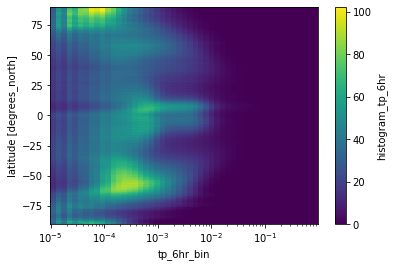

In [67]:
tp_hist_ = tp_hist.compute(retries=5)
tp_hist_[:,1:].plot(xscale='log')

In [68]:
client.close()
cluster.close()